In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import norm

In [2]:
def visualize_normal_KL():
    # 1. Setup Data
    x = np.linspace(-10, 10, 800)
    p_pdf = norm.pdf(x, 0, 1)
    # Slider from -5 to 5
    mu_values = np.round(np.arange(-5, 5.1, 0.2), 2)

    def get_data_for_mu(mu):
        """Calculates Q and the KL integrand for a given mu."""
        q_pdf = norm.pdf(x, mu, 1)
        # p(x) * ln(p(x)/q(x))
        # Small epsilon to prevent log(0)
        integrand = p_pdf * (np.log(p_pdf + 1e-10) - np.log(q_pdf + 1e-10))
        kl_div = 0.5 * (mu**2) # Theoretical KL for N(0,1) and N(mu,1)
        return q_pdf, integrand, kl_div

    # 2. Initial Setup (starting the plot at mu = -5)
    q_start, int_start, kl_start = get_data_for_mu(-5.0)

    fig = go.Figure()

    # TRACE 0: The "Truth" P ~ N(0, 1) -> GREEN
    fig.add_trace(go.Scatter(
        x=x, y=p_pdf, name='P ~ N(0, 1) [Truth]', 
        line=dict(color='green', width=3), 
            fill='tozeroy', fillcolor='rgba(0, 255, 0, 0.05)'
    ))

    # TRACE 1: The moving Q ~ N(mu, 1) -> ORANGE
    fig.add_trace(go.Scatter(
        x=x, y=q_start, name='Q ~ N(μ, 1) [Model]', 
        line=dict(color='orange', width=3)
    ))

    # TRACE 2: The KL Integrand -> BLUE
    fig.add_trace(go.Scatter(
        x=x, y=int_start, name='KL Integrand', 
        line=dict(color='blue', width=2), 
        fill='tozeroy', fillcolor='rgba(0, 0, 255, 0.3)'
    ))

    # 3. Create Frames for the Slider
    frames = []
    for mu in mu_values:
        q, i, kl = get_data_for_mu(mu)
        frames.append(go.Frame(
            data=[
                go.Scatter(x=x, y=p_pdf), # P stays green/fixed
                go.Scatter(x=x, y=q),     # Q moves
                go.Scatter(x=x, y=i)      # Integrand updates (blue)
            ],
            name=str(mu),
            layout=go.Layout(title_text=f"Mean Shift μ = {mu:.1f} | D_KL = {kl:.2f}")
        ))
            # 4. Slider Configuration
    steps = []
    for mu in mu_values:
        step = dict(
            method="animate",
            args=[[str(mu)], dict(mode="immediate", frame=dict(duration=50, redraw=True), transition=dict(duration=0))],
            label=f"{mu:.1f}"
        )
        steps.append(step)

    # 5. Final Layout
    fig.update_layout(
        sliders=[dict(active=0, currentvalue={"prefix": "Shift μ: "}, steps=steps)],
        yaxis=dict(range=[-0.5, 1.5], title="Value"),
        xaxis=dict(range=[-10, 10], title="x"),
        title="KL Divergence Visualization (P=Green, Integrand=Blue)",
        template="plotly_white",
        height=600,
        showlegend=True
    )

    fig.frames = frames
    fig.show()

# Lecture 9: Misspecified Models and Kullback-Leibler Divergence

**Data 145, Spring 2026: Evidence and Uncertainty**  

**Instructors:** Ani Adhikari, William Fithian

---

**Please run all the code cells above before you start reading.** 

---

## 1. Introduction

All our discussions so far have been about parametric families of distributions. With our frequentist hats on, we have imagined our sample $X_1, X_2, \ldots, X_n$ to be i.i.d. draws from some distribution $f_\theta$, and we have tried to estimate $\theta$.

We've done some fine-tuning of our estimates too. For example, when the underlying distribution of the sample is exponential with rate $\lambda$, we know that we can improve upon the MLE $\hat{\lambda} = 1/\bar{X}$ by multiplying it by a factor of $(n-1)/n$. This gives us an unbiased estimator (the MLE is biased) with a smaller variance than the MLE.

That's all fine, but all of our calculations are based on our underlying assumption about the joint distribution of the sampled elements. What if those assumptions are wrong?

For example, suppose we assume that the sample is i.i.d. exponential $(\lambda)$, and we calculate our estimate accordingly, but in fact the sample isn't i.i.d. exponential. Maybe it's i.i.d. with some other distribution, or not i.i.d. at all. Then our calculations will not reflect reality.

This is the problem of a *misspecified model*, and it's a problem we have to face. We will focus on the case where we think the sample is i.i.d. $f_\theta$ but in fact the sample is i.i.d. $g$ for some distribution $g$ that's not a member of the $f$ family. How bad will our estimates be?

Naturally, this depends on how different $g$ is from members of $f$. So it's worth looking at ways to define the difference between two distributions.

In Data 8 and 140, we used the total variation distance (TVD) to measure the distance between two distributions. Stick to the discrete case, forget the parameter $\theta$, and recall that calculating the TVD involves adding terms like $\vert g(x) - f(x) \vert$ for each $x$ in the support of either of the two distributions. Small values of the TVD mean that $f$ and $g$ put almost the same mass on each $x$. 

An alternative to the absolute difference is the ratio $\displaystyle \frac{g(x)}{f(x)}$. A ratio near $1$ mean the two distributions are close at $x$; greater than $1$ means $g$ puts more mass at $x$ than $f_\theta$ does.

This is the same as looking at whether $\log \displaystyle \frac{g(x)}{f_\theta(x)}$ is positive, zero, or negative. And that motivates a definition.

## 2. Definition and Basic Properties

Consider a random variable $X$ that could have one of two probability distributions described by their densities (or pmfs) $g$ and $f$. The [Kullback-Leibler divergence](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-22/issue-1/On-Information-and-Sufficiency/10.1214/aoms/1177729694.full) of the two distributions is defined by

$$
D_{KL}(g \Vert f) ~ = ~ E_g\left( \log \frac{g(X)}{f(X)} \right)
~ = ~ \int_x \log\frac{g(x)}{f(x)} \cdot g(x)dx 
$$

This is a way of measuring how far the distributions are from each other. Notice that the two distributions don't have the same status: the expectation is taken under $g$, which you should think of as the truth whereas $f$ is what we've specified in our model.

The definition implies that if $f$ is small where $g$ is large, the KL divergence will be large. In fact, the definition is only interesting if the support of $g$ is contained in the support of $f$. Otherwise $f(x)$ could be $0$ where $g(x)$ is positive, and the KL divergence would be infinite.

KL divergence has some of the properties of a distance, but not others.

1. If $g = f$ then $D_{KL}(g \Vert f) = 0$. This is clear from the definition.
2. *Gibbs' Inequality*: $D_{KL}(g \Vert f) \ge 0$ with equality if and only if $g = f$.
$$
\begin{align*}
D_{KL}(g \Vert f) ~ &= ~ E_g\left( -\log \frac{f(X)}{g(X)} \right) \\
& \geq -\log\left(E(\frac{f(X)}{g(X)})\right) ~~~ \text{by Jensen's inequality, since } x \to -\log(x) \text{ is convex} \\
&= -\log \int_x \frac{f(x)}{g(x)} \cdot g(x)dx \\
&= -\log \int_x f(x)dx ~ = ~ -\log(1) ~ = ~ 0
\end{align*}
$$

Since $-\log$ is a strictly convex function, equality holds if and only if $f = g$.

**Not symmetric:** But KL divergence is not a distance since in general $D_{KL}(g \Vert f) \neq D_{KL}(f \Vert g)$.

---
### Example
Let $g$ be normal $(\mu_1, \sigma^2)$ and let $f$ be normal $(\mu_2, \sigma^2)$. Let's find $D_{KL}(g \Vert f)$. In your homework, you'll do the case where the variances are different too.

$$
\begin{align*}
\log\frac{g(x)}{f(x)} &= -\frac{(x - \mu_1)^2}{2\sigma^2} + \frac{(x - \mu_2)^2}{2\sigma^2} \\
&= \frac{1}{2\sigma^2}\left((x - \mu_2)^2 - (x - \mu_1)^2\right) \\
&= \frac{1}{2\sigma^2}\left( (2x - \mu_1 - \mu_2)(\mu_1 - \mu_2)\right)
\end{align*}
$$
Since $g$ is normal $(\mu_1, \sigma^2)$,
$$
D_{KL}(g \Vert f) = E_g\left(\frac{1}{2\sigma^2}(2X - \mu_1 - \mu_2)(\mu_1 - \mu_2)\right)
= \frac{(\mu_1 - \mu_2)^2}{2\sigma^2}
$$
As is so often the case with the normal, behavior is nicer than for other distributions. The KL divergence above is symmetric in $\mu_1$ and $\mu_2$.

Not surprisingly, it gets larger and $\mu_2$ gets further away from $\mu_1$. The visualization below takes $\sigma = 1$ and shows:
- g: Normal $(0, 1)$, the green density curve which is the truth
- f: Normal $(\mu, 1)$, the orange density curve which is our model
- The blue curve is the integrand in the definition of $D_{KL}(g \Vert f)$. That is, the blue curve is $\displaystyle \log\frac{g(x)}{f(x)}\cdot g(x)$.
- The blue shaded area is the integral $D_{KL}(g \Vert f)$.

First move the slider to get to $\mu=0$. Then move it to the right so the orange curve moves away from the green. Notice: 
- The blue curve is positive where the truth (green) is higher than the model (orange).
- The green distribution puts a lot of weight near $0$, so the integrand is large there when the blue curve is positive.
- Where the orange curve is higher than the green then the integrand is negative but small because the green weight is small.

By our formula above, $D_{KL}(g \Vert f) = \mu^2/2$ since $\mu_1 = 0$ and $\sigma = 1$. Check that you agree with the calculation of $D_{KL}$ in the title of the graph.

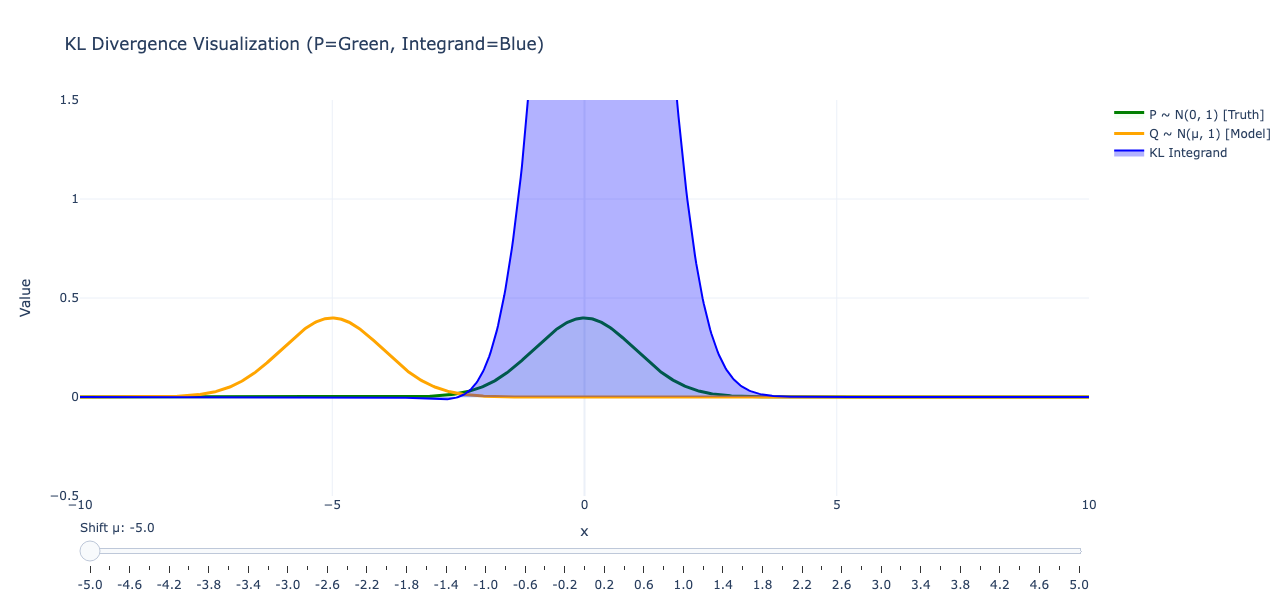

In [3]:
visualize_normal_KL()

## 3. Misspecified Model, the MLE, and KL Divergence ##

Now let's see how the KL divergence is related to the parametric estimation we've been doing since the start of the term.

Suppose you think that you have an  i.i.d. sample from an underlying parametric family $f_\theta$ for some unknown numerical parameter $\theta$. But suppose that in fact the sample consists of i.i.d. draws from $g$ which is not a member of the $f$ family.

For example, suppose you think that your sample is i.i.d. exponential but in fact it's from a gamma distribution with shape parameter $\neq 1$.

To find the MLE of $\theta$, we look for $\hat{\theta}$ that maximizes 

$$
\frac{1}{n}\ell_n(\theta) ~ = ~ \frac{1}{n}\sum_{i=1}^n \log f_\theta(X_i) ~ = ~ \frac{1}{n}\sum_{i=1}^n\ell_1(\theta; X_i)
$$

Since the true underlying distribution is $g$, the WLLN implies

$$
\frac{1}{n}\sum_{i=1}^n \log f_\theta(X_i) ~ \stackrel{P}{\to} ~ E_g(\log f_\theta(X))
$$
Keep in mind that $g$ is the truth, so probabilities must be calculated under $g$.

So for large $n$, the $\hat{\theta}$ that maximizes the log-likelihood should with high probability be close to the $\theta^*$ that maximizes $E_g(\log f_\theta(X))$. This is a hand-wavy statement but it should be believable.

Now 
$$
D_{KL}(g \Vert f_\theta) ~ = ~ E_g(\log g(X)) - E_g(\log f_\theta(X))
$$
So
$$
E_g(\log f_\theta(X)) ~ = ~ E_g(\log g(X)) - D_{KL}(g \Vert f_\theta)
$$

The first term on the right hand side doesn't involve $\theta$. So finding the $\theta^*$ that *maximizes* the left hand side is equivalent to finding the $\theta^*$ that *minimizes* the KL divergence $D_{KL}(g \Vert f_\theta)$.

In other words, if the MLE $\hat{\theta}$ is computed under the misspecified model, then the estimated distribution $f_{\hat{\theta}}$ should be close to $f_\theta^*$ which minimizes $D_{KL}(g \Vert f_\theta)$. In this sense, the estimated distribution is the closest you can come to $g$ among members of the family $f_\theta$.

For the hand-wavy argument above to be true, we have to assume smoothness of $f$ and $g$, the existence of a unique MLE under $f_\theta$, and the existence of a unique $\theta^*$ that minimizes $D_{KL}(g \Vert f_\theta)$. There are some other regularity conditions as well. But don't worry about all that. 

## 4. Sandwich Estimator of Variance
All our asymptotics for the MLE, including the results about the Fisher information, assumed that our model was correct. But if the model was misspecified then those results don't hold. So let's see what we can say about the asymptotic distribution of the MLE calculated under a misspecified model.

What we know so far:
1. The MLE $\hat{\theta}$ maximizes the log-likelihood and hence also $\frac{1}{n}\sum_{i=1}^n \log f_\theta(X_i)$.
2. When $n$ is large, with high probability $\frac{1}{n}\sum_{i=1}^n \log f_\theta(X_i)$ is close to $E_g(\log f_\theta(X))$.
3. So when $n$ is large, with high probability the MLE $\hat{\theta}$ is close to the $\theta^*$ that minimizes $D_{KL}(g \Vert f_\theta)$.

We will now quantify what we mean by "close" in Statement 3. Let us see how close $\hat{\theta}$ is to $\theta^*$. We will use our old friend the Taylor approximation.

Since $\hat{\theta}$ is the MLE,
$$
0 = \ell_n'(\hat{\theta}) \approx \ell_n'(\theta^*) + (\hat{\theta} - \theta^*)\ell_n^"(\theta^*)
$$
So, by a move we've made before,
$$
\sqrt{n}(\hat{\theta} - \theta^*) \approx -\frac{\frac{1}{\sqrt{n}}\ell_n'(\theta^*)}{\frac{1}{n}\ell_n^"(\theta^*)}
$$
**The denominator:**
$$
\frac{1}{n}\ell_n^"(\theta^*) \stackrel{P}{\to} E_g(\ell_1^"(\theta^*; X))
$$
**The numerator:** Since $\ell_1'(\theta; X) = \frac{d}{d\theta} \log f_\theta(X)$, and 
$\theta^*$ maximizes $E_g(\log f_\theta(X))$, we have
$$
0 = \frac{d}{d\theta} E_g(\log f_\theta(X)) = E_g\left[\ell_1'(\theta; X)_{\theta = \theta^*}\right]
$$
by blithely switching the expectation and the derivative as we've done before. So $E_g(\ell_n'(\theta^*)) = 0$.

So the numerator
$$
\frac{1}{\sqrt{n}}\ell_n'(\theta^*) = \frac{1}{\sqrt{n}}\sum_{i=1}^n\ell_1'(\theta^*; X_i)
$$ 
is approximately normal by the CLT, with mean $0$ and variance $Var_g(\ell_1'(\theta^*; X))$.

Slutsky's Lemma then implies
$$
\sqrt{n}(\hat{\theta} - \theta^*) \stackrel{d}{\to} N\left( 0, \frac{Var_g(\ell_1'(\theta^*; X))}{[E_g(\ell_1^"(\theta^*; X))]^2} \right)
$$

The variance can be written as
$$
\frac{1}{E_g(\ell_1^"(\theta^*; X))} \cdot Var_g(\ell_1'(\theta^*; X)) \cdot \frac{1}{E_g(\ell_1^"(\theta^*; X))}
$$
which (I'm not kidding) looks like two slices of bread with a piece of something in between, that is, a sandwich. This makes more sense when the parameter is multidimensional and the factors are matrices and their inverses, but let's not go there.

---

#### Estimating the Standard Error
The good news is that if we calculate the MLE under the misspecified model, we have a formula for its standard error. Moreover, if you set $g = f_{\theta^*}$, meaning that the model is good, then the formula is the same as our original asymptotic variance for the MLE in terms of $I(\theta^*)$.

The bad news is that when the model is misspecified, we need means and variances under $g$, which we might not be able to find.

However if the sample is large, we can estimate all the pieces from the sample. The sample was drawn under $g$. So sample means and variances should be close to the true means and variances under $g$ if the sample is large.

The plan:
- Estimate $\theta^*$ by the MLE $\hat{\theta}$.
- Estimate $Var_g(\ell_1')$ by the sample variance of $\ell_1'$.
- Estimate $E_g(\ell_1^")$ by the sample mean of $\ell_1^"$.

---

### Example
Suppose our model is that $X_1, X_2, \ldots, X_n$ are i.i.d. exponential with rate $\lambda$, and we find the MLE $\hat{\lambda}$ under that assumption. Then we know: 
- $\hat{\lambda} = \displaystyle \frac{1}{\bar{X}}$
- $\ell_1'(\lambda; X) = \displaystyle \frac{1}{\lambda} - X$
- $\ell_1^"(\lambda; X) = \displaystyle -\frac{1}{\lambda^2}$

The true model is some unknown $g$. This distribution should be reflected in a large sample. So we can find the sandwich estimator of the standard error of $\hat{\lambda}$ by executing our plan.

Estimate $Var_g(\ell_1'(\lambda^*; X))$ by the sample variance of $W_1, W_2, \ldots, W_n$ where $W_i = \frac{1}{\hat{\lambda}} - X_i$. The sample mean of the $W$'s is $\frac{1}{\hat{\lambda}} - \bar{X}$, so
the sample variance of the $W$'s is
$$
S^2 = \frac{1}{n} \sum_{i=1}^n (W_i - \bar{W})^2 ~ = ~ \frac{1}{n} \sum_{i=1}^n (X_i - \bar{X})^2
$$
by plugging in the definitions of $W_i$ and $\bar{W}$. You can divide by $n-1$ instead of $n$ if you wish, but it won't matter since $n$ is large.

Estimate $E_g(\ell_1^"(\lambda^*; X))$ by the sample mean 
$$
\frac{1}{n} \ell_n^"(\hat{\lambda}) = -\frac{1}{\hat{\lambda}^2}
$$
Put it all together:
$$
\text{sandwich estimator} ~ = ~ S^2 \hat{\lambda}^4 = \frac{S^2}{\bar{X}^4}
$$
and hence the sandwich estimator of the standard error of $\hat{\lambda}$ is $\displaystyle \frac{S}{\sqrt{n}\bar{X}^2}$.

Your homework includes a simulation study of these calculations. You will generate data under $g$, find the MLE of $\theta$ under $f_\theta$, and then compare the empirical distribution of that MLE with what the theory says.

## 5. Next Lecture
By now you will be acutely aware of some of the problems with parametric models. So next time we'll look at some non-parametric methods just based on the empirical distribution of our sample. The main goal will be to examine the bootstrap method for confidence intervals covered in Data 8 and Data 100, and to see if we can do better.